# Week 8 - Tensorflow and CNN for Topic Classification
## Jupyter
The Jupyter Notebook is an open-source web application that allows you to create and share documents that contain live code, equations, visualizations and explanatory text. Uses include: data cleaning and transformation, numerical simulation, statistical modeling, machine learning and much more.

## Docker
It is much more convenient to use a docker image containing `Tensorflow(r1.0.1)` and `Jupyter`, as well as other common `python(r2.7)` packages.

```dockerfile
FROM jupyter/scipy-notebook

MAINTAINER Jupyter Project <jupyter@googlegroups.com>

# Install Python 2 Tensorflow
RUN conda install --quiet --yes -n python2 'tensorflow=1.0.1'
```

```bash
sudo docker build . -t your_name/cs503_tensorflow_jupyter
sudo docker login
sudo docker push your_name/cs503_tensorflow_jupyter
```

**Run**
``` bash
docker run -it --rm -p 8888:8888 your_name/cs503_tensorflow_jupyter
```

Go to localhost:8888 to start.


## Data
### Data Format
We will use 500 news with labeled topic to train our model. The format of the data is 
```
[#class_number],[news_title],[news_description],[news_source]
```

Two example:

```
3,Trump: Netanyahu should 'hold back' on settlements,"President Donald Trump told Israeli Prime Minister Benjamin Netanyahu Wednesday that the US is going to push for a peace deal with the Palestinians and asked Israel ""to hold back"" on settlement construction.",cnn

3,"Trump: UN treats Israel 'very, very unfairly' - CNN Video",President Donald Trump and Israeli Prime Minister Benjamin Netanyahu hold a joint press conference at the White House.,cnn
```

The class is one of total 17 classes:
```
 1: Colleges & Schools
 2: Environmental
 3: World
 4: Entertainment
 5: Media
 6: Politics & Government
 7: Regional News
 8: Religion
 9: Sports
10: Technology
11: Traffic
12: Weather
13: Economic & Corp
14: Advertisements
15: Crime
16: Other
17: Magazine
```

Pandas Dataframe is a useful data structure for data science. Let's look at few of them in pandas dataframe.


In [38]:
import pandas as pd

DATA_SET_FILE = './labeled_news.csv'

df = pd.read_csv(DATA_SET_FILE, header=None)

print df.head(10)

   0                                                  1  \
0  3  Trump: Netanyahu should 'hold back' on settlem...   
1  3  Trump: UN treats Israel 'very, very unfairly' ...   
2  3      Where Trump and Netanyahu stand on key issues   
3  3  Trump: West Bank settlements 'don't help' the ...   
4  3                         Trump watch: Live coverage   
5  3      Why Netanyahu must stand up to Israel's right   
6  3  Flynn called victim of political assassination...   
7  3  Trump aides were in constant touch with senior...   
8  6  Will this undocumented mom be there when her k...   
9  6  In college, Trump aide Stephen Miller led cont...   

                                                   2    3  
0  President Donald Trump told Israeli Prime Mini...  cnn  
1  President Donald Trump and Israeli Prime Minis...  cnn  
2  "Tomorrow's world will be different -- and it ...  cnn  
3  President Donald Trump told Israeli newspaper ...  cnn  
4  President Trump hosts world leaders. Michael F.

### Statistics
Let's first take a look at our data from a statistics perspective.

> We can use pandas to do a quick data analysis: http://machinelearningmastery.com/quick-and-dirty-data-analysis-with-pandas/

In [1]:
import pandas as pd

DATA_SET_FILE = './labeled_news.csv'

df = pd.read_csv(DATA_SET_FILE, header=None)


print "class description"
print df[0].describe()

print """

=====================

"""

print "source description"
print df[3].describe()


class description
count    500.0000
mean       7.6140
std        3.3953
min        1.0000
25%        6.0000
50%        6.0000
75%        9.0000
max       17.0000
Name: 0, dtype: float64




source description
count     500
unique     11
top       cnn
freq      132
Name: 3, dtype: object


**Class Distribution**

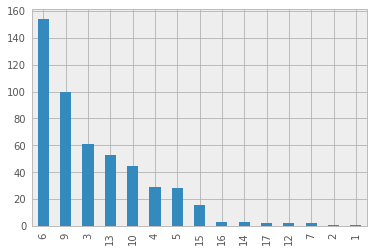

In [9]:
import matplotlib.pyplot as plt

pd.options.display.mpl_style = 'default'

df[0].value_counts().plot(kind="bar")


**Source Distribution**

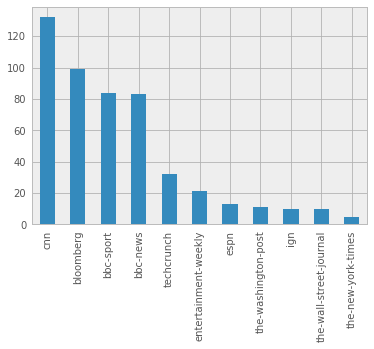

In [10]:
df[3].value_counts().plot(kind="bar")

## Vocabulary Embedding
Tensorflow cannot handle String directly. Therefore, we need to convert String into vectors. This is called embedding.

One example:
```
    Sentence 1: "I like apple"
    Sentence 2: "I like banana"
    Sentence 3: "I eat apple"
```

We scan all 3 sentences then we found there are 5 unique words: 
```
    ['I', 'like', 'eat', 'apple', 'banana']
```
Now we can use number to represent each of them:
```
    [0, 1, 2, 3, 4]
```
So, the three sentences can be encoded into:
```
    Sentence 1: [0, 1, 3]
    Sentence 2: [0, 1, 4]
    Sentence 3: [0, 2, 3]
```

### VocabularyProcessor
Tensorflow provides a easy-to-use tool to do embedding.


In [44]:
import numpy as np
import tensorflow as tf

MAX_DOCUMENT_LENGTH = 5

vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(MAX_DOCUMENT_LENGTH)

# fit and transform
sentences = [
    "I like apple",
    "I like banana",
    "I eat apple"
]

embedded_sentences = np.array(list(vocab_processor.fit_transform(sentences)))
print embedded_sentences

print 'Total unique words: %d' % len(vocab_processor.vocabulary_)

print ""
# just fit: unseen words will be interpreted as 0
new_sentences = [
    "This is a brand new sentence which we never seen before and is very long",
    "I hate doing homework!",
    "I like banana",
    "I eat apple"
]

new_embedded_sentences = np.array(list(vocab_processor.fit_transform(new_sentences)))
print new_embedded_sentences


[[1 2 3 0 0]
 [1 2 4 0 0]
 [1 5 3 0 0]]
Total unique words: 6

[[0 0 0 0 0]
 [1 0 0 0 0]
 [1 2 4 0 0]
 [1 5 3 0 0]]


### One-hot Embedding
We have converted the string into an integer vector. But that is not good enough. We need to convert a word into one-hot vector:
```
Assume we only have 10 unique words.

    0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
    2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
    3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    4 -> [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
    5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
    6 -> [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
    7 -> [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
    8 -> [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
    9 -> [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
```

Thus, one setence is converted into a matrix:

```
Assume there are only 5 unique words:

    "I like apple" 
-> 
    [1 2 3 0 0] 
->
    [
        [0, 1, 0, 0, 0],  => I
        [0, 0, 1, 0, 0],  => like
        [0, 0, 0, 1, 0],  => apple
        [1, 0, 0, 0, 0],  => padding
        [1, 0, 0, 0, 0]   => padding
    ]
```

#### Tensorflow embed_sequence
Tensorflow provides tf.contrib.layers.embed_sequence which can help use with one-hot embedding. 

In real world, we don't use native [0, 1] way to label a word, but use a real number.

In [36]:
import tensorflow as tf

vocab_size = 6
embed_dim = 6

sentences = [
    [1, 2, 3, 0, 0]
]
embedded_setences = tf.contrib.layers.embed_sequence(sentences, vocab_size, embed_dim)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    result = sess.run(embedded_setences)
    print(result)


[[[-0.15365833  0.60118073 -0.16130793 -0.51932704  0.27153915  0.20354986]
  [ 0.15726829 -0.29960257  0.66570419 -0.34065881  0.22046089  0.12072778]
  [ 0.06263393  0.14344341 -0.02278173 -0.58802676  0.19248533 -0.42651936]
  [ 0.51072448 -0.03707522 -0.15842998 -0.63320112  0.49047202 -0.46788716]
  [ 0.51072448 -0.03707522 -0.15842998 -0.63320112  0.49047202 -0.46788716]]]


## Convolutional Neural Networks (CNNs)
We cannot dive deep into what is convolution here. 

But here is a great article about CNNs for NLP:
http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/

### Convolution
![image](http://deeplearning.stanford.edu/wiki/images/6/6c/Convolution_schematic.gif)

### Pooling
![image](http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/11/Screen-Shot-2015-11-05-at-2.18.38-PM.png)

## Put Eveyrthing Together

In [46]:
# -*- coding: utf-8 -*-

import numpy as np
import os
import pandas as pd
import pickle
import shutil
import tensorflow as tf


from sklearn import metrics

learn = tf.contrib.learn

DATA_SET_FILE = './labeled_news.csv'

MAX_DOCUMENT_LENGTH = 500
N_CLASSES = 17


EMBEDDING_SIZE = 100
N_FILTERS = 10
WINDOW_SIZE = 10
FILTER_SHAPE1 = [WINDOW_SIZE, EMBEDDING_SIZE]
FILTER_SHAPE2 = [WINDOW_SIZE, N_FILTERS]
POOLING_WINDOW = 4
POOLING_STRIDE = 2

LEARNING_RATE = 0.01
STEPS = 200

def generate_cnn_model(n_classes, n_words):
    """2 layer CNN to predict from sequence of words to a class."""
    def cnn_model(features, target):
        # Convert indexes of words into embeddings.
        # This creates embeddings matrix of [n_words, EMBEDDING_SIZE] and then
        # maps word indexes of the sequence into [batch_size, sequence_length,
        # EMBEDDING_SIZE].

        target = tf.one_hot(target, n_classes, 1, 0)
        word_vectors = tf.contrib.layers.embed_sequence(
            features, vocab_size=n_words, embed_dim=EMBEDDING_SIZE, scope='words')

        word_vectors = tf.expand_dims(word_vectors, 3)
        
        with tf.variable_scope('CNN_layer1'):
            # Apply Convolution filtering on input sequence.
            conv1 = tf.contrib.layers.convolution2d(
                word_vectors, N_FILTERS, FILTER_SHAPE1, padding='VALID')
            # Add a RELU for non linearity.
            conv1 = tf.nn.relu(conv1)
            # Max pooling across output of Convolution+Relu.
            pool1 = tf.nn.max_pool(
                conv1,
                ksize=[1, POOLING_WINDOW, 1, 1],
                strides=[1, POOLING_STRIDE, 1, 1],
                padding='SAME')
            # Transpose matrix so that n_filters from convolution becomes width.
            pool1 = tf.transpose(pool1, [0, 1, 3, 2])
      
        with tf.variable_scope('CNN_layer2'):
            # Second level of convolution filtering.
            conv2 = tf.contrib.layers.convolution2d(
                pool1, N_FILTERS, FILTER_SHAPE2, padding='VALID')
            # Max across each filter to get useful features for classification.
            pool2 = tf.squeeze(tf.reduce_max(conv2, 1), squeeze_dims=[1])

        # Apply regular WX + B and classification.
        logits = tf.contrib.layers.fully_connected(pool2, n_classes, activation_fn=None)
        loss = tf.contrib.losses.softmax_cross_entropy(logits, target)

        train_op = tf.contrib.layers.optimize_loss(
          loss,
          tf.contrib.framework.get_global_step(),
          optimizer='Adam',
          learning_rate=LEARNING_RATE)

        return ({
          'class': tf.argmax(logits, 1),
          'prob': tf.nn.softmax(logits)
        }, loss, train_op)

    return cnn_model


def main(unused_argv):
    # Prepare training and testing data
    df = pd.read_csv(DATA_SET_FILE, header=None)

    # Random shuffle
    df.sample(frac=1)

    train_df = df[0:400]
    test_df = df.drop(train_df.index)

    # x - news title, y - class
    x_train = train_df[1]
    y_train = train_df[0]
    x_test = test_df[1]
    y_test = test_df[0]

    # Process vocabulary
    vocab_processor = learn.preprocessing.VocabularyProcessor(MAX_DOCUMENT_LENGTH)
    x_train = np.array(list(vocab_processor.fit_transform(x_train)))
    x_test = np.array(list(vocab_processor.transform(x_test)))

    n_words = len(vocab_processor.vocabulary_)
    print('Total words: %d' % n_words)
  
    # Build model
    classifier = learn.Estimator(
        model_fn=generate_cnn_model(N_CLASSES, n_words))

    # Train and predict
    classifier.fit(x_train, y_train, steps=STEPS)

    # Evaluate model
    y_predicted = [
        p['class'] for p in classifier.predict(x_test, as_iterable=True)
    ]
    print y_predicted

    score = metrics.accuracy_score(y_test, y_predicted)
    print('Accuracy: {0:f}'.format(score))

if __name__ == '__main__':
    tf.app.run(main=main)




Total words: 2127
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7af2aa8850>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat.

SystemExit: 